In [1]:
import os

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Import required packages
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier


import torchvision.models as modelsvgg

import time


# Detect and set GPU on local device
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("No GPU device found")

## 1. Load the datasets

For the project, we provide a training set with 50000 images in the directory `../data/images/` with:
- noisy labels for all images provided in `../data/noisy_label.csv`;
- clean labels for the first 10000 images provided in `../data/clean_labels.csv`. 

In [2]:
# [DO NOT MODIFY THIS CELL]

# load the images
n_img = 50000
n_noisy = 40000
imgs = np.empty((n_img,32,32,3))
for i in range(n_img):
    img_fn = f'../data/images/{i+1:05d}.png'
    imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)

# load the labels
clean_labels = np.genfromtxt('../data/clean_labels.csv', delimiter=',', dtype="int8")
noisy_labels = np.genfromtxt('../data/noisy_labels.csv', delimiter=',', dtype="int8")

For illustration, we present a small subset (of size 8) of the images with their clean and noisy labels in `clean_noisy_trainset`. You are encouraged to explore more characteristics of the label noises on the whole dataset. 

Clean labels:
 frog truck truck  deer   car   car  bird horse
Noisy labels:
  cat   dog truck  frog   dog  ship  bird  deer


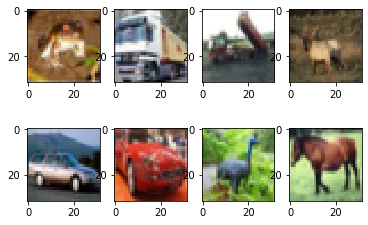

In [3]:
# [DO NOT MODIFY THIS CELL]

fig = plt.figure()

ax1 = fig.add_subplot(2,4,1)
ax1.imshow(imgs[0]/255)
ax2 = fig.add_subplot(2,4,2)
ax2.imshow(imgs[1]/255)
ax3 = fig.add_subplot(2,4,3)
ax3.imshow(imgs[2]/255)
ax4 = fig.add_subplot(2,4,4)
ax4.imshow(imgs[3]/255)
ax1 = fig.add_subplot(2,4,5)
ax1.imshow(imgs[4]/255)
ax2 = fig.add_subplot(2,4,6)
ax2.imshow(imgs[5]/255)
ax3 = fig.add_subplot(2,4,7)
ax3.imshow(imgs[6]/255)
ax4 = fig.add_subplot(2,4,8)
ax4.imshow(imgs[7]/255)

# The class-label correspondence
classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# print clean labels
print('Clean labels:')
print(' '.join('%5s' % classes[clean_labels[j]] for j in range(8)))
# print noisy labels
print('Noisy labels:')
print(' '.join('%5s' % classes[noisy_labels[j]] for j in range(8)))


## 2. The predictive model

We consider a baseline model directly on the noisy dataset without any label corrections. RGB histogram features are extracted to fit a logistic regression model.

### 2.1. Baseline Model

In [4]:
# [DO NOT MODIFY THIS CELL]
# RGB histogram dataset construction
no_bins = 6
bins = np.linspace(0,255,no_bins) # the range of the rgb histogram
target_vec = np.empty(n_img)
feature_mtx = np.empty((n_img,3*(len(bins)-1)))
i = 0
for i in range(n_img):
    # The target vector consists of noisy labels
    target_vec[i] = noisy_labels[i]
    
    # Use the numbers of pixels in each bin for all three channels as the features
    feature1 = np.histogram(imgs[i][:,:,0],bins=bins)[0] 
    feature2 = np.histogram(imgs[i][:,:,1],bins=bins)[0]
    feature3 = np.histogram(imgs[i][:,:,2],bins=bins)[0]
    
    # Concatenate three features
    feature_mtx[i,] = np.concatenate((feature1, feature2, feature3), axis=None)
    i += 1

In [5]:
# [DO NOT MODIFY THIS CELL]
# Train a logistic regression model 
clf = LogisticRegression(random_state=0).fit(feature_mtx, target_vec)

For the convenience of evaluation, we write the following function `predictive_model` that does the label prediction. **For your predictive model, feel free to modify the function, but make sure the function takes an RGB image of numpy.array format with dimension $32\times32\times3$  as input, and returns one single label as output.**

In [6]:
# [DO NOT MODIFY THIS CELL]
def baseline_model(image):
    '''
    This is the baseline predictive model that takes in the image and returns a label prediction
    '''
    feature1 = np.histogram(image[:,:,0],bins=bins)[0]
    feature2 = np.histogram(image[:,:,1],bins=bins)[0]
    feature3 = np.histogram(image[:,:,2],bins=bins)[0]
    feature = np.concatenate((feature1, feature2, feature3), axis=None).reshape(1,-1)
    return clf.predict(feature)

### 2.2.1. VGG Model

In [3]:
def VGG():
   ## Loading VGG16 model
    base_model = VGG16(weights="imagenet", include_top=False, input_shape=(32,32,3))
    base_model.trainable = False
       
    flatten_layer = layers.Flatten()
    dense_layer_1 = layers.Dense(50, activation='relu')
    dense_layer_2 = layers.Dense(20, activation='relu')
    prediction_layer = layers.Dense(10, activation='softmax')
    
    model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(32,32,3)),
    base_model,
    flatten_layer,
    dense_layer_1,
    dense_layer_2,
    prediction_layer
])
    
    model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy'],
)
    
    return model

### 2.2.2. VGG Model I and II

In [4]:
def model_I(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    return np.argmax(model_vgg.predict(image),axis=1)

    
def model_II(image):
    '''
    This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
    '''
    return np.argmax(model2_vgg.predict(image), axis = 1)

### 2.3.1. CNN Model

CNN model, as the most common image processing algorithm, is introduced in this project. We combine 40k images with noisy labels and 5k images with clean labels in the data set as the train set. 

The construction of CNN is a stack of Conv2D and MaxPooling2D layers. Use Relu and softmax as the non-linear activation function to transfrom the data so that they could be linearly seperable. Finally, feed the last output tensor from the convolutional base into a final Dense layer with 10 outputs to perform classification.

For weight optimization, we choose Adam optimizer with learning_rate to be 0.001. The objective function is categorical cross entropy. 

Early stopping is added to avoid overfitting by monitoring the validation loss. We tune the patience parameter to be 3, which means the training process will check at end of every epoch whether the validation loss is no longer decreasing, and training will be stopped if there are 3 epochs with no improvement.

Reference: 
https://www.tensorflow.org/tutorials/images/cnn
https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping

In [3]:
def CNN():
    model = tf.keras.Sequential([
        layers.Rescaling(1./255, input_shape=(32,32,3)),
        tf.keras.layers.Conv2D(32,(3,3),padding='valid', activation ='relu', input_shape=(32,32,3)),
        tf.keras.layers.MaxPooling2D((2,2)),
        
        tf.keras.layers.Conv2D(64,(3,3),padding='valid', activation ='relu'),
        tf.keras.layers.MaxPooling2D((2,2)),
    
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(100, activation = 'relu'),
        tf.keras.layers.Dropout(0.5),
    
        tf.keras.layers.Dense(10, activation = 'softmax')        
                                ])
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']) 
        
    return model

### 2.3.2. Cross Validation

In [4]:
def CNN_cross_validator(image, t_x, val_x, t_y, val_y):
    start = time.process_time()
    model_cnn = CNN()
    print(model_cnn.summary())
    es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)
    model_cnn.fit(t_x, t_y, epochs=50, validation_split=0.2, batch_size=512, callbacks=[es])
    end = time.process_time() - start
    print("processing time = ", end, "s")
    
    def model_I(image):
        '''
        This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
        '''
        return np.argmax(model_cnn.predict(image), axis = 1)
   
    test_loss, test_acc = model_cnn.evaluate(val_x, val_y)
    predict_labels = model_I(imgs)
    pl = list(predict_labels)
    train_x_pl, test_x_pl, train_y_pl, test_y_pl = train_test_split(imgs, pl, test_size=0.2, random_state = 5)
    train_y_pl = tf.one_hot(train_y_pl, depth = 10)
    start = time.process_time()
    model2_cnn = CNN()
    model2_cnn.fit(train_x_pl, train_y_pl, epochs=50, validation_split=0.2, batch_size=512, callbacks=[es])
    end = time.process_time() - start
    print("processing time = ", end, "s")
    
    test_loss2, test_acc2 = model2_cnn.evaluate(val_x, val_y)
    
    def model_II(image):
        '''
        This function should takes in the image of dimension 32*32*3 as input and returns a label prediction
        '''
        return np.argmax(model2_cnn.predict(image), axis = 1)
    
    results = np.array((test_acc, test_acc2))
    return results

## 3. Evaluation

For assessment, we will evaluate your final model on a hidden test dataset with clean labels by the `evaluation` function defined as follows. Although you will not have the access to the test set, the function would be useful for the model developments. For example, you can split the small training set, using one portion for weakly supervised learning and the other for validation purpose. 

In [3]:
# [DO NOT MODIFY THIS CELL]
def evaluation(model, test_labels, test_imgs):
    y_true = test_labels
    y_pred = []
    for image in test_imgs:
        y_pred.append(model(image))
    print(classification_report(y_true, y_pred))

### 3.1. Baseline Model Evaluation

In [10]:
# [DO NOT MODIFY THIS CELL]
# This is the code for evaluating the prediction performance on a testset
# You will get an error if running this cell, as you do not have the testset
# Nonetheless, you can create your own validation set to run the evlauation
n_test = 10000
test_labels = np.genfromtxt('../data/test_labels.csv', delimiter=',', dtype="int8")
test_imgs = np.empty((n_test,32,32,3))
for i in range(n_test):
    img_fn = f'../data/test_images/test{i+1:05d}.png'
    test_imgs[i,:,:,:]=cv2.cvtColor(cv2.imread(img_fn),cv2.COLOR_BGR2RGB)
evaluation(baseline_model, test_labels, test_imgs)

              precision    recall  f1-score   support

           0       0.33      0.46      0.38      1000
           1       0.21      0.31      0.25      1000
           2       0.20      0.04      0.07      1000
           3       0.19      0.12      0.14      1000
           4       0.24      0.48      0.32      1000
           5       0.20      0.11      0.14      1000
           6       0.24      0.34      0.28      1000
           7       0.31      0.04      0.08      1000
           8       0.27      0.43      0.33      1000
           9       0.20      0.12      0.15      1000

    accuracy                           0.24     10000
   macro avg       0.24      0.24      0.21     10000
weighted avg       0.24      0.24      0.21     10000



The overall accuracy is $0.24$, which is better than random guess (which should have a accuracy around $0.10$). For the project, you should try to improve the performance by the following strategies:

- Consider a better choice of model architectures, hyperparameters, or training scheme for the predictive model;
- Use both `clean_noisy_trainset` and `noisy_trainset` for model training via **weakly supervised learning** methods. One possible solution is to train a "label-correction" model using the former, correct the labels in the latter, and train the final predictive model using the corrected dataset.
- Apply techniques such as $k$-fold cross validation to avoid overfitting;
- Any other reasonable strategies.

### 3.2. VGG Evaluation

In [5]:
n_folds=3
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)
cl = list(clean_labels)
nl = list(noisy_labels[10000:])

#save the model history in a list after fitting so that we can plot later
cnn_history = []

In [8]:
# Training and test data
train_x_cl, test_x, train_y_cl, test_y = train_test_split(imgs[0:10000], cl, test_size=0.2, random_state = 5)
train_x_nl, test_x_nl, train_y_nl, test_y_nl = train_test_split(imgs[10000:], nl, test_size=0.2, random_state = 5)
train_x = np.concatenate((train_x_cl, train_x_nl))
train_y = np.concatenate((train_y_cl, train_y_nl))
train_y = tf.one_hot(train_y, depth=10)
test_y = tf.one_hot(test_y, depth=10)

start = time.process_time()
model_vgg = VGG()
print(model_vgg.summary())
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=3,  restore_best_weights=True)
model_vgg.fit(train_x, train_y, epochs=50, validation_split=0.2, batch_size=512, callbacks=[es])
print("======="*12, end="\n\n\n")
end = time.process_time() - start
print("processing time = ", end, "s")

test_loss, test_acc = model_vgg.evaluate(test_x, test_y)
del train_x, train_y, train_x_cl, train_y_cl, train_x_nl, train_y_nl, test_x_nl, test_y_nl

print("======="*12, end="\n\n\n")
predict_labels = model_I(imgs)
pl = list(predict_labels)
train_x_pl, test_x_pl, train_y_pl, test_y_pl = train_test_split(imgs, pl, test_size=0.2, random_state = 5)
train_y_pl = tf.one_hot(train_y_pl, depth = 10)
start = time.process_time()
model2_vgg = VGG()
model2_vgg.fit(train_x_pl, train_y_pl, epochs=50, validation_split=0.2, batch_size=512, callbacks=[es])
end = time.process_time() - start
print("processing time = ", end, "s")
    
test_loss2, test_acc2 = model2_vgg.evaluate(test_x, test_y)

# Reset GPU device
if gpus:
  for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
else:
  print("No GPU device found")
del test_x, test_y, train_x_pl, test_x_pl, train_y_pl, test_y_pl

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 vgg16 (Functional)          (None, 1, 1, 512)         14714688  
                                                                 
 flatten_2 (Flatten)         (None, 512)               0         
                                                                 
 dense_6 (Dense)             (None, 50)                25650     
                                                                 
 dense_7 (Dense)             (None, 20)                1020      
                                                                 
 dense_8 (Dense)             (None, 10)                210       
                                                                 
Total params: 14,741,568
Trainable params: 26,880
Non-

### 3.3. CNN Evaluation

In [6]:
for i in range(n_folds):
    if gpus:
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    else:
     print("No GPU device found")
    print("Training on Fold: ",i+1)

    train_x_cl, test_x, train_y_cl, test_y = train_test_split(imgs[0:10000], cl, test_size=0.2, random_state = 5)
    train_x_nl, test_x_nl, train_y_nl, test_y_nl = train_test_split(imgs[10000:], nl, test_size=0.2, random_state = 5)
    train_x = np.concatenate((train_x_cl, train_x_nl))
    train_y = np.concatenate((train_y_cl, train_y_nl))
    train_y = tf.one_hot(train_y, depth=10)
    test_y = tf.one_hot(test_y, depth=10)
    cnn_history.append(CNN_cross_validator(imgs, train_x, test_x, train_y, test_y))
    if gpus:
      for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)
    else:
      print("No GPU device found")
    del train_x, train_y, test_x, test_y, train_x_cl, train_y_cl, train_x_nl, test_x_nl, train_y_nl, test_y_nl
    print("======="*12, end="\n\n\n")

Training on Fold:  1
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 32, 32, 3)         0         
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None,

63/63 [==============================] - 0s 3ms/step - loss: 1.5328 - accuracy: 0.5885


Training on Fold:  2
Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_2 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_4 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
          

63/63 [==============================] - 1s 16ms/step - loss: 0.6259 - accuracy: 0.7713 - val_loss: 0.5884 - val_accuracy: 0.7837
Epoch 24/50
63/63 [==============================] - 1s 16ms/step - loss: 0.6183 - accuracy: 0.7747 - val_loss: 0.6051 - val_accuracy: 0.7811
processing time =  33.65625 s
63/63 [==============================] - 0s 2ms/step - loss: 1.4074 - accuracy: 0.6070


Training on Fold:  3
Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling_4 (Rescaling)     (None, 32, 32, 3)         0         
                                                                 
 conv2d_8 (Conv2D)           (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 15, 15, 32)       0         
 2D)                                                             
                                      

63/63 [==============================] - 1s 16ms/step - loss: 0.7645 - accuracy: 0.7260 - val_loss: 0.7101 - val_accuracy: 0.7401
Epoch 20/50
63/63 [==============================] - 1s 16ms/step - loss: 0.7537 - accuracy: 0.7286 - val_loss: 0.6997 - val_accuracy: 0.7484
Epoch 21/50
63/63 [==============================] - 1s 16ms/step - loss: 0.7492 - accuracy: 0.7328 - val_loss: 0.6940 - val_accuracy: 0.7462
Epoch 22/50
63/63 [==============================] - 1s 16ms/step - loss: 0.7277 - accuracy: 0.7379 - val_loss: 0.6925 - val_accuracy: 0.7456
Epoch 23/50
63/63 [==============================] - 1s 16ms/step - loss: 0.7106 - accuracy: 0.7429 - val_loss: 0.7093 - val_accuracy: 0.7434
processing time =  32.59375 s
63/63 [==============================] - 0s 2ms/step - loss: 1.2733 - accuracy: 0.6100




In [7]:
cnn_modelI_acc = np.mean(cnn_history,axis = 0)[0]
cnn_modelII_acc = np.mean(cnn_history,axis = 0)[1]
print("CNN modelI accuracy = ", cnn_modelI_acc, "\nCNN modelII accuracy = ", cnn_modelII_acc)

CNN modelI accuracy =  0.6033333539962769 
CNN modelII accuracy =  0.6018333435058594
